# VSD Data Visualization Notebook

This notebook demonstrates the visualization capabilities for VSD (Voltage-Sensitive Dye) video data, including:
- Frame sequence visualization
- Spatial dynamics analysis
- Normalization options

## Setup and Imports


In [57]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Ensure project root is on sys.path for imports
PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import project modules
from src.data.data_loader import load_dataset
from src.utils.visualization import plot_frames_sequence, plot_spatial_dynamics

print("Imports completed successfully!")


Imports completed successfully!


## Configuration

Set up the data path and visualization parameters:


In [58]:
# Data configuration
HDF5_PATH = Path(r"G:\My Drive\HDF5_DATA_AFTER_PREPROCESSING2\vsd_video_data.hdf5")

# Visualization parameters
FRAME_START = 27
FRAME_END = 68
CLIPPING_RANGE = (0, 2)
GRID_ROWS = 10
GRID_COLS = 10

print(f"Data path: {HDF5_PATH}")
print(f"Frame range: {FRAME_START} - {FRAME_END}")
print(f"Grid layout: {GRID_ROWS}×{GRID_COLS}")


Data path: G:\My Drive\HDF5_DATA_AFTER_PREPROCESSING2\vsd_video_data.hdf5
Frame range: 27 - 68
Grid layout: 10×10


## Data Loading and Inspection

First, let's inspect the HDF5 file structure and load a sample of data:


In [59]:
def inspect_hdf5(hdf5_path: Path):
    """Inspect the structure of the HDF5 file"""
    import h5py
    
    if not hdf5_path.exists():
        print(f"HDF5 file not found: {hdf5_path}")
        return
    
    print(f"Inspecting HDF5 file: {hdf5_path.name}")
    print("=" * 50)
    
    with h5py.File(hdf5_path, 'r') as f:
        def _printer(name, obj):
            try:
                shape = getattr(obj, 'shape', None)
                dtype = getattr(obj, 'dtype', None)
                if shape is not None:
                    print(f"{name}: shape={shape}, dtype={dtype}")
            except Exception:
                pass
        
        f.visititems(_printer)

# Inspect the data file
inspect_hdf5(HDF5_PATH)


Inspecting HDF5 file: vsd_video_data.hdf5
boromir_011221a/condsXn1: shape=(10000, 256, 8), dtype=float64
boromir_011221a/condsXn2: shape=(10000, 256, 8), dtype=float64
boromir_011221a/condsXn3: shape=(10000, 256, 8), dtype=float64
boromir_011221a/condsXn4: shape=(10000, 256, 8), dtype=float64
boromir_011221a/condsXn5: shape=(10000, 256, 8), dtype=float64
boromir_011221a/condsXn6: shape=(10000, 256, 8), dtype=float64
boromir_011221a/condsXn7: shape=(10000, 256, 8), dtype=float64
boromir_011221b/condsXn1: shape=(10000, 256, 5), dtype=float64
boromir_011221b/condsXn2: shape=(10000, 256, 4), dtype=float64
boromir_011221b/condsXn3: shape=(10000, 256, 5), dtype=float64
boromir_011221b/condsXn4: shape=(10000, 256, 4), dtype=float64
boromir_011221b/condsXn5: shape=(10000, 256, 4), dtype=float64
boromir_011221b/condsXn6: shape=(10000, 256, 5), dtype=float64
boromir_011221b/condsXn7: shape=(10000, 256, 4), dtype=float64
boromir_011221c/condsXn1: shape=(10000, 256, 8), dtype=float64
boromir_01122

## Dataset Configuration

Configure the dataset with normalization and frame slicing options:


In [ ]:
# Dataset configuration
cfg = {
    "dataset": "vsd",
    "vsd_hdf5_path": HDF5_PATH,
    "normalize": True,
    "normalization_type": "baseline_robust",
    "baseline_frame": 20,
    "frame_start": 1,
    "frame_end": 100,
    "batch_size": 4,
    "num_workers": 0,  # Set to 0 for Jupyter compatibility
    "shuffle": True
}

print("Dataset Configuration:")
for key, value in cfg.items():
    print(f"   {key}: {value}")


Dataset Configuration:
   dataset: vsd
   vsd_hdf5_path: G:\My Drive\HDF5_DATA_AFTER_PREPROCESSING2\vsd_video_data.hdf5
   normalize: True
   normalization_type: baseline_robust
   baseline_frame: 20
   frame_start: 1
   frame_end: 100
   batch_size: 4
   num_workers: 0
   shuffle: True


## Load Random Sample Directly

Load a random sample directly from HDF5 and apply normalization without creating a data loader:


In [61]:
# Load random sample directly from HDF5 and normalize
print("Loading random sample directly from HDF5...")

# Import required modules for direct data loading
import h5py
from src.data.normalization import get_normalizer

def load_random_sample_direct(hdf5_path, frame_start, frame_end, normalization_type, baseline_frame):
    """Load a random sample directly from HDF5 and normalize it"""
    
    # First, get all available samples to choose from
    available_samples = []
    with h5py.File(hdf5_path, 'r') as f:
        for group_name in f.keys():
            group = f[group_name]
            for dataset_name in group.keys():
                dataset = group[dataset_name]
                num_trials = dataset.shape[-1]
                for trial_index in range(num_trials):
                    available_samples.append((group_name, dataset_name, trial_index))
    
    print(f"Found {len(available_samples)} available samples")
    
    # Select a random sample
    random_sample_idx = random.randint(0, len(available_samples) - 1)
    group_name, dataset_name, trial_index = available_samples[random_sample_idx]
    
    print(f"Selected sample {random_sample_idx}: {group_name}/{dataset_name}, trial {trial_index}")
    
    # Load the raw data
    with h5py.File(hdf5_path, 'r') as f:
        dataset = f[group_name][dataset_name]
        # Data is (pixels, frames, trials), slice the correct trial
        data_slice = dataset[:, :, trial_index]
        
        # Apply frame slicing
        if frame_end is not None:
            data_slice = data_slice[:, frame_start:frame_end + 1]
        else:
            data_slice = data_slice[:, frame_start:]
    
    # Reshape to (channels, frames, height, width)
    height, width = 100, 100
    frames = data_slice.shape[1]
    reshaped_data = data_slice.reshape(height, width, frames)
    
    # Convert to tensor: (1, frames, 100, 100)
    video_tensor = torch.from_numpy(reshaped_data).unsqueeze(0).permute(0, 3, 1, 2)
    
    print(f"Raw video tensor shape: {video_tensor.shape}")
    print(f"Raw video range: [{video_tensor.min():.4f}, {video_tensor.max():.4f}]")
    
    # Setup normalization
    print(f"Setting up {normalization_type} normalization...")
    normalizer = get_normalizer(
        normalization_type=normalization_type,
        baseline_frame=baseline_frame,
        cache_dir="cache"
    )
    
    # Compute normalization statistics
    normalization_stats = normalizer.compute_stats(
        hdf5_path=hdf5_path,
        frame_start=frame_start,
        frame_end=frame_end
    )
    
    # Apply normalization
    print("Applying normalization...")
    normalized_video = normalizer.normalize(video_tensor, normalization_stats)
    
    # Create mask tensor
    mask_tensor = torch.zeros(1, frames, height, width, dtype=torch.float32)
    
    return {
        'video': normalized_video,
        'mask': mask_tensor,
        'raw_video': video_tensor,
        'normalization_stats': normalization_stats,
        'sample_index': random_sample_idx,
        'group_name': group_name,
        'dataset_name': dataset_name,
        'trial_index': trial_index
    }

# Load the random sample
sample_data = load_random_sample_direct(
    hdf5_path=cfg["vsd_hdf5_path"],
    frame_start=cfg["frame_start"],
    frame_end=cfg["frame_end"],
    normalization_type=cfg["normalization_type"],
    baseline_frame=cfg["baseline_frame"]
)

video_tensor = sample_data['video']
raw_video_tensor = sample_data['raw_video']

print(f"Sample loaded successfully!")
print(f"Normalized video shape: {video_tensor.shape}")
print(f"Normalized video range: [{video_tensor.min():.4f}, {video_tensor.max():.4f}]")
print(f"Raw video range: [{raw_video_tensor.min():.4f}, {raw_video_tensor.max():.4f}]")


Loading random sample directly from HDF5...
Found 212 available samples
Selected sample 177: boromir_011221d/condsXn4, trial 2
Raw video tensor shape: torch.Size([1, 100, 100, 100])
Raw video range: [0.9494, 1.0518]
Setting up baseline_robust normalization...
Loaded cached statistics from cache\vsd_video_data_frames_1_100_baseline_20.pkl
Applying normalization...


KeyError: 'median'

## Normalization Statistics

Display the computed normalization statistics:

In [ ]:
# Display sample information and normalization statistics
sample_index = sample_data['sample_index']
group_name = sample_data['group_name']
dataset_name = sample_data['dataset_name']
trial_index = sample_data['trial_index']
normalization_stats = sample_data['normalization_stats']

print("Sample Information:")
print(f"   Sample Index: {sample_index}")
print(f"   Group: {group_name}")
print(f"   Dataset: {dataset_name}")
print(f"   Trial: {trial_index}")

print("\nNormalization Statistics:")
if 'mean' in normalization_stats and 'std' in normalization_stats:
    print(f"   Mean range: [{normalization_stats['mean'].min():.4f}, {normalization_stats['mean'].max():.4f}]")
    print(f"   Std range: [{normalization_stats['std'].min():.4f}, {normalization_stats['std'].max():.4f}]")
    print(f"   Mean shape: {normalization_stats['mean'].shape}")
    print(f"   Std shape: {normalization_stats['std'].shape}")
elif 'median' in normalization_stats and 'iqr' in normalization_stats:
    print(f"   Median range: [{normalization_stats['median'].min():.4f}, {normalization_stats['median'].max():.4f}]")
    print(f"   IQR range: [{normalization_stats['iqr'].min():.4f}, {normalization_stats['iqr'].max():.4f}]")
    print(f"   Median shape: {normalization_stats['median'].shape}")
    print(f"   IQR shape: {normalization_stats['iqr'].shape}")

print(f"\nNormalization Effect:")
print(f"   Raw video std: {raw_video_tensor.std():.4f}")
print(f"   Normalized video std: {video_tensor.std():.4f}")
print(f"   Raw video mean: {raw_video_tensor.mean():.4f}")
print(f"   Normalized video mean: {video_tensor.mean():.4f}")


Sample Information:
   Sample Index: 124
   Group: boromir_011221c
   Dataset: condsXn5
   Trial: 2

Normalization Statistics:
   Mean range: [0.9972, 1.0026]
   Std range: [0.0002, 0.0164]
   Mean shape: torch.Size([1, 1, 100, 100])
   Std shape: torch.Size([1, 1, 100, 100])

Normalization Effect:
   Raw video std: 0.0020
   Normalized video std: 1.2904
   Raw video mean: 1.0004
   Normalized video mean: 0.4985


## Frame Sequence Visualization

Visualize a sequence of frames from the selected sample:


Plotting frame sequence for sample 124...


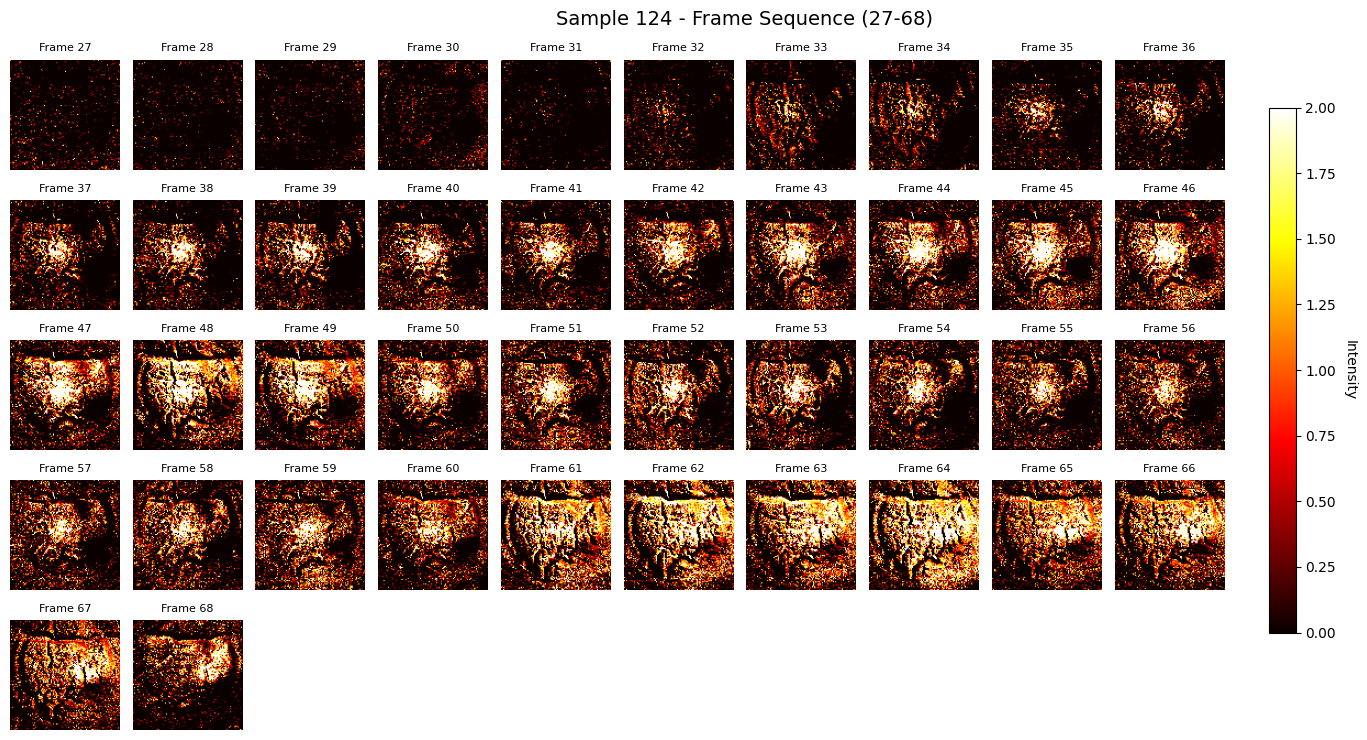

Frame sequence visualization completed!


In [ ]:
# Plot frame sequence
print(f"Plotting frame sequence for sample {sample_index}...")

fig_frames = plot_frames_sequence(
    video_tensor=video_tensor,
    start_frame=FRAME_START,
    end_frame=FRAME_END,
    clipping=CLIPPING_RANGE,
    cols=10,
    title=f"Sample {sample_index} - Frame Sequence ({FRAME_START}-{FRAME_END})",
    show_plot=True
)

print("Frame sequence visualization completed!")


## Spatial Dynamics Analysis

Analyze the spatial dynamics by showing temporal patterns across different spatial regions:


Plotting spatial dynamics for sample 124...


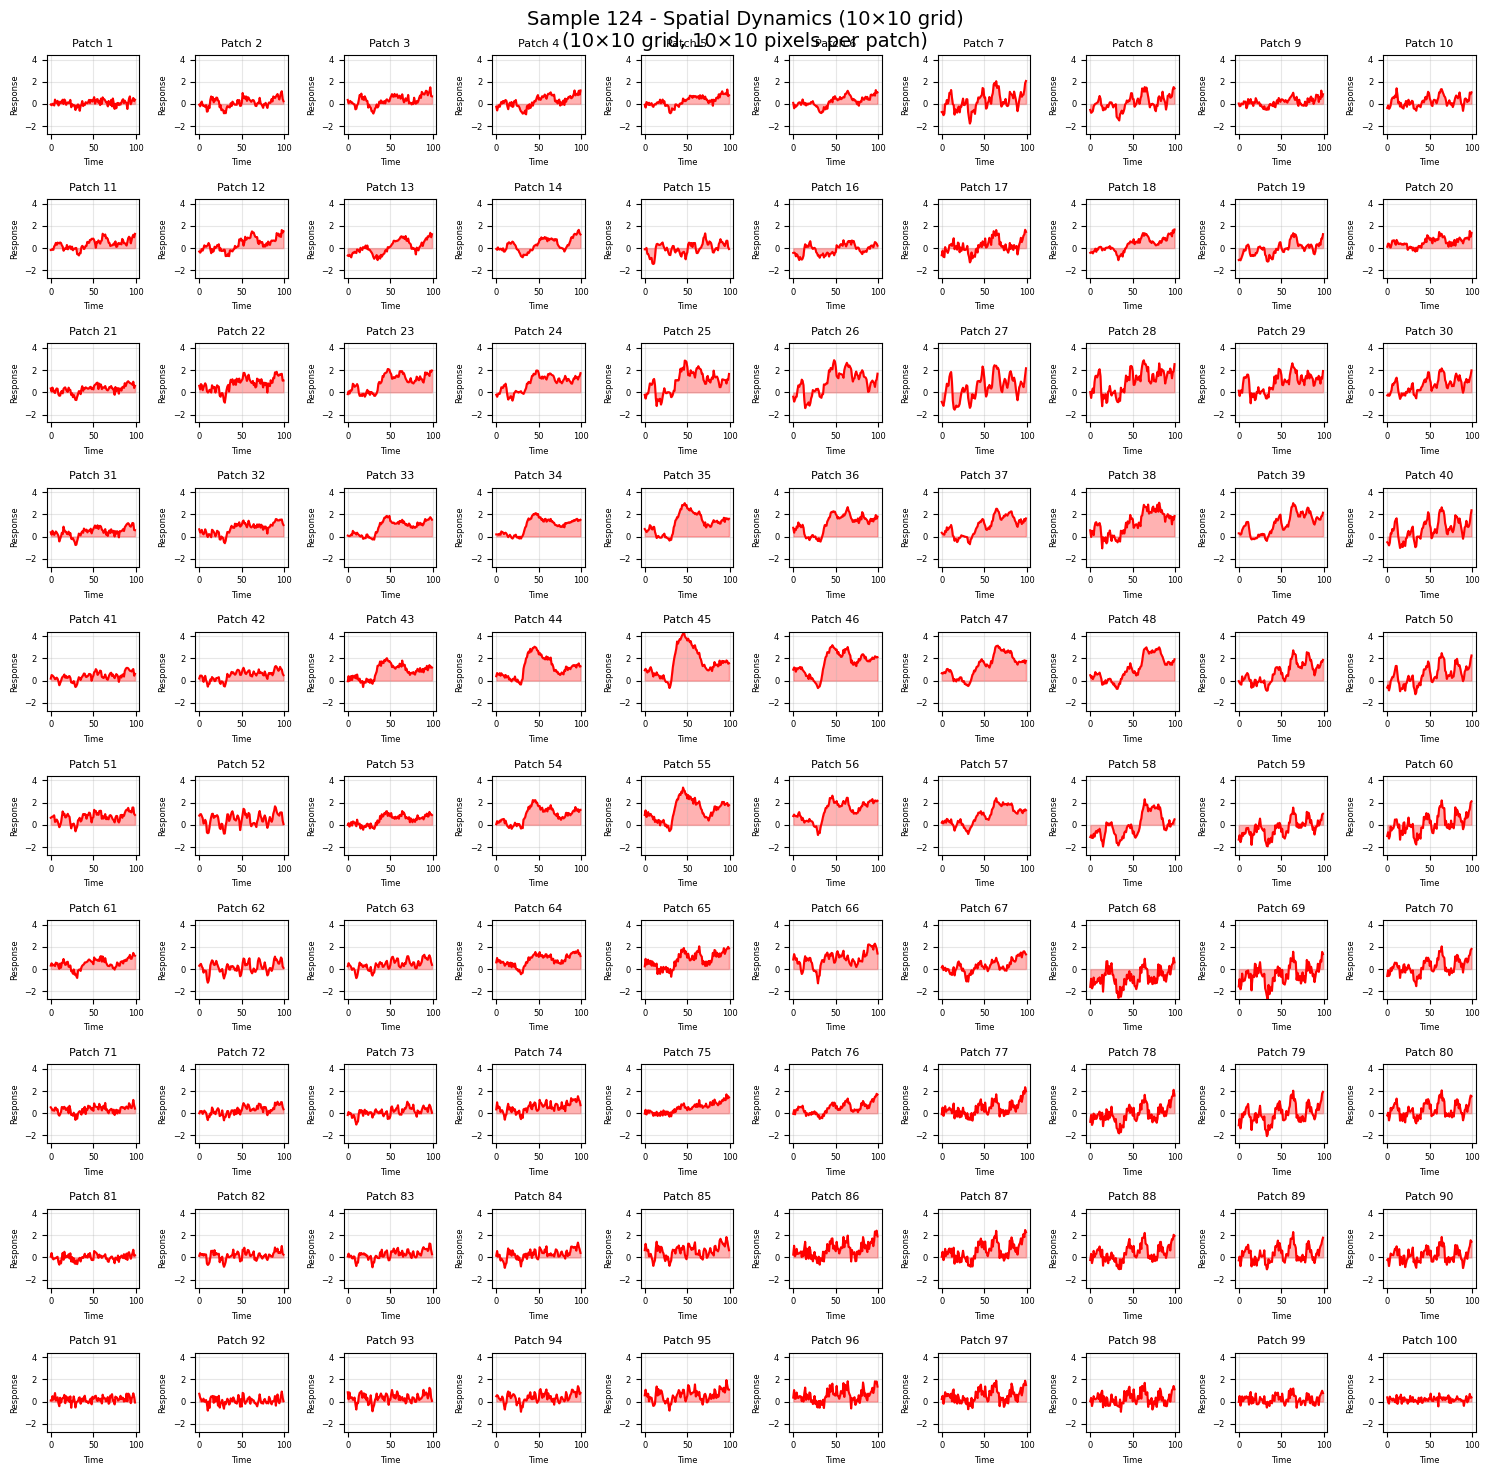

Spatial dynamics visualization completed!


In [ ]:
# Plot spatial dynamics
print(f"Plotting spatial dynamics for sample {sample_index}...")

fig_dynamics = plot_spatial_dynamics(
    video_tensor=video_tensor,
    grid_rows=GRID_ROWS,
    grid_cols=GRID_COLS,
    title=f"Sample {sample_index} - Spatial Dynamics ({GRID_ROWS}×{GRID_COLS} grid)",
    show_plot=True
)

print("Spatial dynamics visualization completed!")
